# Sto learning 


In [1]:
import matplotlib.pyplot as plt
import dgl
from torch.utils.data import DataLoader
import torch
import time
import os
import sys
sys.path.insert(0, "../lib/")
import laplacian
import ninja
import sys
import utils
import model
import graphs
from utils import set_device
from laplacian import normalized_laplacian


# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = set_device(verbose=True)

cuda available


# MNIST

In [2]:
# Downloads the dataset if not found locally
from mnist import check_mnist_dataset_exists, datasampler, MNISTDataset, MNIST_rand

_ = check_mnist_dataset_exists()

nb_selected_train_data = 55000
nb_selected_test_data = 10000

train_data, train_labels, test_data, test_labels, val_data, val_labels= datasampler(
    nb_selected_train_data, nb_selected_test_data
)

trainset = MNIST_rand(train_data, train_labels, removal_rate=0.25)
valset = MNIST_rand(val_data, val_labels)
testset = MNIST_rand(test_data, test_labels)

## Visualise the dataset

Label: tensor(5.)
graph: DGLGraph(num_nodes=784, num_edges=2810,
         ndata_schemes={}
         edata_schemes={})
Largest eigenvalue: 1.9999999999999998
Smallest eigenvalue: 2.3316970707326413e-15


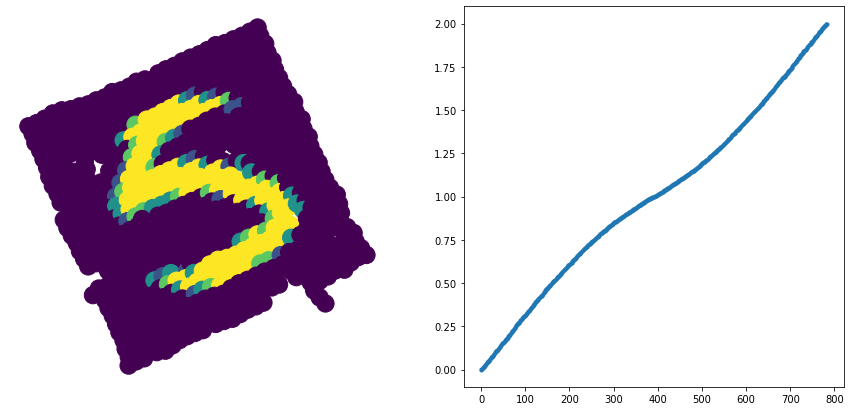

In [3]:
import networkx as nx
import random
from ninja import GeigplotL
plt.figure(figsize=(15,7))

plt.subplot(121)
g_demo, l_demo , s_demo= valset[random.randrange(5000)]
nx.draw_kamada_kawai(g_demo.to_networkx().to_undirected(),node_color=s_demo)
print('Label:',l_demo)
print('graph:',g_demo)

plt.subplot(122)
GeigplotL(g_demo)
plt.show()



# Model definition for training

In [4]:
from model import DGL_mean_Classifier, Classifier, DGL_global_pooling_Classifier
# model_parameters
in_features = 1
first_conv_out = 64
second_conv_out = 128
hidden_layer_classifier = 250
k = 5
n_classes = 10

net = DGL_mean_Classifier(
    in_features, 
    first_conv_out, 
    second_conv_out, 
    hidden_layer_classifier, 
    n_classes, 
    k,
    readout="max"
)

print(net)
if torch.cuda.is_available():
    net.to(device)

DGL_mean_Classifier(
  (layers): ModuleList(
    (0): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=1, out_features=64, bias=False)
        (1): Linear(in_features=1, out_features=64, bias=False)
        (2): Linear(in_features=1, out_features=64, bias=False)
        (3): Linear(in_features=1, out_features=64, bias=False)
        (4): Linear(in_features=1, out_features=64, bias=False)
      )
    )
    (1): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=64, out_features=128, bias=False)
        (1): Linear(in_features=64, out_features=128, bias=False)
        (2): Linear(in_features=64, out_features=128, bias=False)
        (3): Linear(in_features=64, out_features=128, bias=False)
        (4): Linear(in_features=64, out_features=128, bias=False)
      )
    )
    (2): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=128, out_features=256, bias=False)
        (1): Linear(in_features=128, out_features=256, bias=False)
        (2): L

In [6]:
from utils import load_model
net.load_state_dict(load_model('Cheb_max_rand_orig'))

<All keys matched successfully>

# Training pipe

In [7]:
import torch.optim as optim
import torch.nn as nn
#
from utils import collate, collate2
#

train_loader = DataLoader(trainset, batch_size=50,
                         shuffle=True, collate_fn=collate, drop_last=True, pin_memory=False)
val_loader =  DataLoader(valset, batch_size=300,
                         shuffle=False, collate_fn=collate, drop_last=True, pin_memory=False)
test_loader =  DataLoader(testset, batch_size=300,
                         shuffle=False, collate_fn=collate, drop_last=True, pin_memory=False)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)

epoch_losses = []

In [8]:
def train(model, device, data_loader, epochs, loss_func, optimizer, scheduler):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        t0 = time.time()

        for iter, (data, label, signal) in enumerate(data_loader):
            data, label, signal = data.to(device), label.to(device), signal.to(device)

            output = model(data, 
                           signal.float().view(-1, 1).to(device),
                           (torch.ones(200)*2).to(device))
            loss = loss_func(output, label.long().to(device))

            # sum up batch loss
            epoch_loss += loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        epoch_loss /= iter + 1
        
        val_loss = test(net, device, val_loader, False)

        scheduler.step()

        print(
            "Epoch {} loss - train {:.4f} - val {:.4f} - Acc: {} ({:.1f}%) in {:.1f}s".format(
                epoch, epoch_loss, val_loss, correct,
            100 * correct / len(data_loader.dataset), time.time() - t0
            )
        )
        epoch_losses.append([epoch_loss, val_loss])

In [11]:
def test(model, device, data_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    tot_label = []
    tot_pred = []

    with torch.no_grad():
        for iter, (data, label, signal) in enumerate(data_loader):
            
            data, label, signal = data.to(device), label.to(device), signal.to(device)

            output = model(data, signal.view(-1, 1).float(), (torch.ones(300)*2).to(device))
            #if verbose and iter == 0:
                #print(output[0:5], output.size())
            # sum up batch loss
            test_loss += loss_func(output, label.long().to(device)).item()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

            tot_label.append(label.cpu())
            tot_pred.append(pred.cpu())

    # for the classification report
    tot_label = torch.stack(tot_label).view(-1).cpu()
    tot_pred = torch.stack(tot_pred).view(-1).cpu()

    test_loss /= iter + 1

    if verbose:
        print('\n Average loss per epoch: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        # BATCHED DGL EXAMPLE
        import sklearn
        from sklearn.metrics import classification_report

        print(sklearn.metrics.classification_report(tot_label, tot_pred))

    else:
        return test_loss

## Training time

In [12]:
test(net,device,test_loader)
torch.cuda.empty_cache()


 Average loss per epoch: 0.3599, Accuracy: 8730/10000 (87%)

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       969
         1.0       0.98      0.98      0.98      1123
         2.0       0.75      0.83      0.79      1023
         3.0       0.91      0.87      0.89      1000
         4.0       0.81      0.94      0.87       970
         5.0       0.76      0.79      0.77       886
         6.0       0.92      0.82      0.87       946
         7.0       0.94      0.80      0.87      1017
         8.0       0.95      0.94      0.95       964
         9.0       0.83      0.87      0.85      1002

    accuracy                           0.88      9900
   macro avg       0.89      0.88      0.88      9900
weighted avg       0.89      0.88      0.88      9900



In [ ]:
train(net, device, train_loader, 20, loss_func,optimizer, scheduler)

In [ ]:
plt.title("cross entropy averaged over minibatches, over epochs")
plt.plot(epoch_losses)
plt.legend(['train','val'])
plt.show()

In [ ]:
torch.cuda.empty_cache()

## Test Metrics

In [ ]:
test(net,device,test_loader)
torch.cuda.empty_cache()

## Saving

In [ ]:
from utils import save_model

save_model("Cheb_max_rand_orig", net)